In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arviz as az
from sklearn.linear_model import QuantileRegressor
import pymc as pm
import pytensor
import pytensor.tensor as pt
from src.generate_data import generate_data

In [13]:
# Generate example data list
followers, time_of_week, seasonality, engagements, log_followers = generate_data(seed=1, n=50, follower_dist="NB")
df = pd.concat([pd.Series(followers), pd.Series(time_of_week), pd.Series(engagements), pd.Series(log_followers)], axis=1)
df = df.set_axis(["followers", "time_of_week","engagements","log_followers"], axis=1, copy=False)

# Print the first 6 rows
print(df.head())

   followers  time_of_week  engagements  log_followers
0       3000     59.494678   186.988139       8.006701
1       4000     49.474953   314.769114       8.294300
2       3000     21.560756   234.689340       8.006701
3       8000     24.714179   357.001122       8.987322
4          0    106.192046     5.000000       0.000000


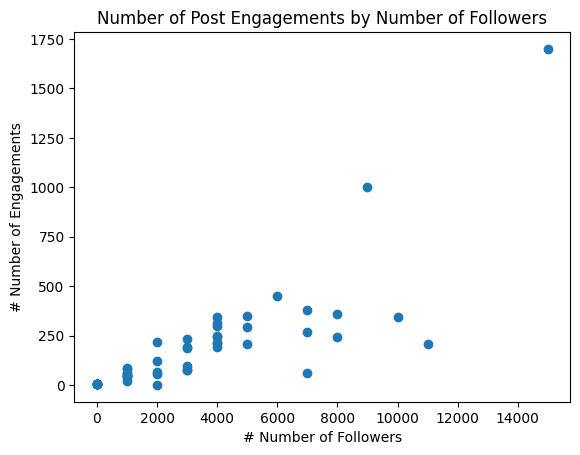

In [14]:
plt.scatter(followers, engagements)
plt.xlabel("Number of Followers")
plt.ylabel("Number of Engagements")
plt.title("Number of Post Engagements by Number of Followers")
plt.show()

Log Transformation

/var/folders/cp/2vygt6wd1zq2dl9rjnzq0zxc0000gn/T/ipykernel_97428/1631081485.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(followers), np.log(engagements + 1))


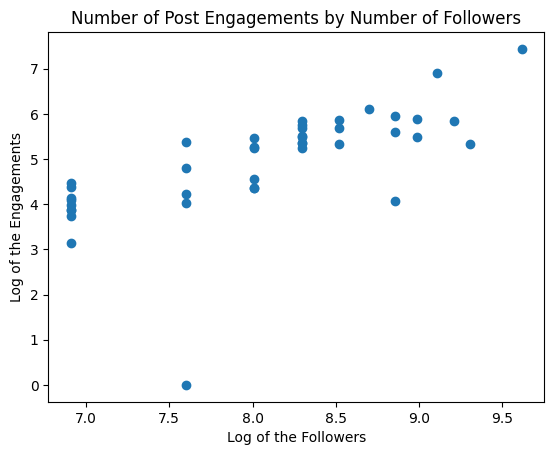

In [20]:
plt.scatter(np.log(followers), np.log(engagements + 1))
plt.xlabel("Log of the Followers")
plt.ylabel("Log of the Engagements")
plt.title("Number of Post Engagements by Number of Followers")
plt.show()

Standard Linear Model (Ignore Heteroscedascicity)

In [21]:
# Add a constant
df = sm.add_constant(df)
# Fit the model
lm = sm.OLS(df['engagements'], df.loc[:,['const','followers']])
res = lm.fit()
# Print the model summary
print(res.summary())

# Calculat the predictions
y_pred = res.params[1]*df['followers'] + res.params[0]
# Calculate the std of the error
residuals = df['engagements'] - y_pred
std = np.std(residuals)

                            OLS Regression Results                            
Dep. Variable:            engagements   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     79.41
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           9.59e-12
Time:                        16:15:56   Log-Likelihood:                -327.47
No. Observations:                  50   AIC:                             658.9
Df Residuals:                      48   BIC:                             662.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.9616     35.469     -0.958      0.3

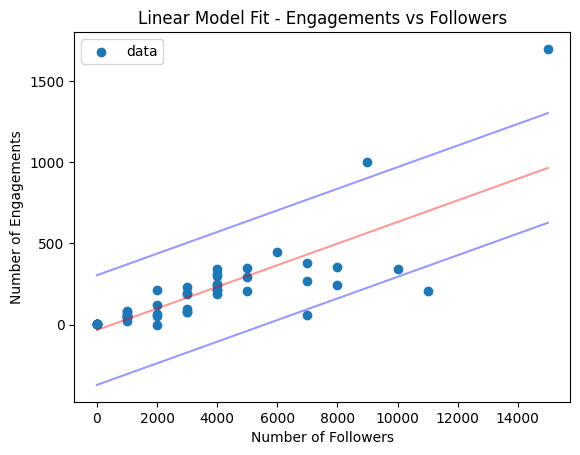

In [22]:
# Set up the plot by calculating the fit and 95% percentile
x_plot = xr.DataArray(np.linspace(df['followers'].min(), df['followers'].max(), 100), dims="plot_id")
y_OLS = res.params[0] + res.params[1]*x_plot
y_OLSn95 = res.params[0] + res.params[1]*x_plot + 2*std
y_OLSn5 = res.params[0] + res.params[1]*x_plot - 2*std

# Plot the Linear Model Fit and Uncertainty
plt.scatter(df['followers'], df['engagements'], label="data")
plt.plot(x_plot, y_OLS, alpha=0.4, color="red")
plt.plot(x_plot, y_OLSn95, alpha=0.4, color="blue")
plt.plot(x_plot, y_OLSn5, alpha=0.4, color="blue")
plt.xlabel("Number of Followers")
plt.ylabel("Number of Engagements")
plt.legend(loc=0)
plt.title("Linear Model Fit - Engagements vs Followers");

Quantile Regression

In [23]:
# Fit the Quantile Regression model
X = np.array(df.loc[:,['followers']]).reshape(-1,1)
y = np.array(df['engagements'])

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
predictions = {}
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver="highs")
    y_pred = qr.fit(X, y).predict(X)
    predictions[quantile] = y_pred

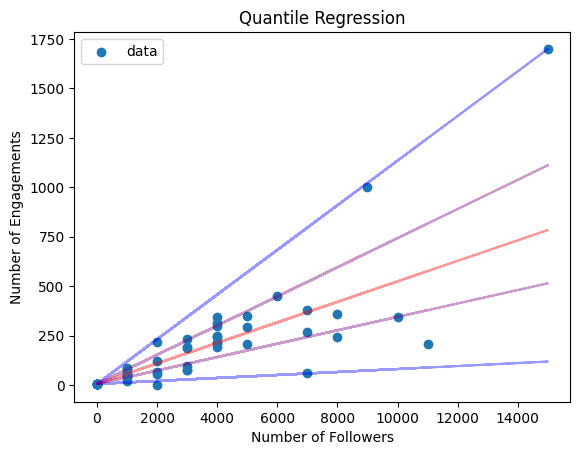

In [24]:
# Plot the Quantile Regression results
plt.scatter(df['followers'], df['engagements'], label="data")
plt.plot(df['followers'], predictions[0.5], alpha=0.4, color="red")
plt.plot(df['followers'], predictions[0.05], alpha=0.4, color="blue")
plt.plot(df['followers'], predictions[0.95], alpha=0.4, color="blue")
plt.plot(df['followers'], predictions[0.25], alpha=0.4, color="purple")
plt.plot(df['followers'], predictions[0.75], alpha=0.4, color="purple")
plt.xlabel("Number of Followers")
plt.ylabel("Number of Engagements")
plt.legend(loc=0)
plt.title("Quantile Regression");

Bayesian Conditional Variance with PyMC

In [25]:
# Create and train the bayesian model
with pm.Model() as model:
    X = pm.Data("x", followers, dims="obs_id", mutable=False)

    # define priors
    intercept = pm.Uniform("intercept", lower=np.min(engagements), upper=np.max(engagements))
    slope = pm.Uniform("slope", lower = -1, upper = 1)
    
    # Define the sigma relationship
    sig_m = pm.Uniform('sigma_m', lower=0, upper=1)
    sigma = pm.Deterministic('sig', np.log(np.exp(sig_m*df['followers'] + 1)))

    # Define the mean of th normal distribution
    mu = pm.Deterministic("mu", slope*df['followers'] + intercept, dims="obs_id")

    # Define the likelihood function
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=df['engagements'], dims="obs_id")

    # inference
    trace = pm.sample(1000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, slope, sigma_m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


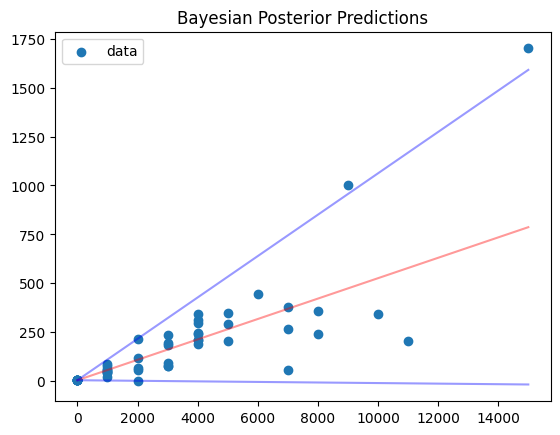

In [30]:
# Get the sigma from the trace
sigma = np.mean(np.concatenate(trace.posterior['sigma_m']))

# Extract the posterior
posterior = az.extract(trace, num_samples=10)
lines = np.mean(posterior["intercept"]) + np.mean(posterior["slope"]) * x_plot
lines_p95 = np.mean(posterior["intercept"]) + np.mean(posterior["slope"]) * x_plot + 2*sigma*x_plot
lines_n95 = np.mean(posterior["intercept"]) + np.mean(posterior["slope"]) * x_plot - 2*sigma*x_plot

# Plot the results
plt.scatter(df['followers'], df['engagements'], label="data")
plt.plot(x_plot, lines.transpose(), alpha=0.4, color="red")
plt.plot(x_plot, lines_p95.transpose(), alpha=0.4, color="blue")
plt.plot(x_plot, lines_n95.transpose(), alpha=0.4, color="blue")
plt.legend(loc=0)
plt.title("Bayesian Posterior Predictions");

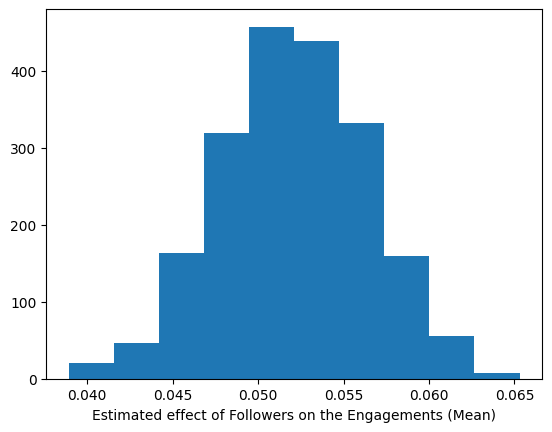

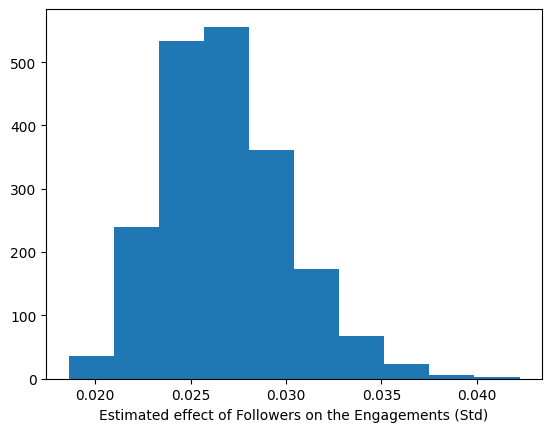

In [32]:
# Plot the posterior distributions of the parameters
plt.hist(np.concatenate(trace.posterior['slope']))
plt.xlabel("Estimated effect of Followers on the Engagements (Mean)")
plt.show()


# Plot the posterior distribution of the sigma beta
plt.hist(np.concatenate(trace.posterior['sigma_m']))
plt.xlabel("Estimated effect of Followers on the Engagements (Std)")
plt.show()